In [1]:
DATA_FPATH = '/net/lts2gdk0/mnt/scratch/lts2/nallapar/rb-prof/data/Jan_2024/Lina/full_Test_LIG_riboclette.h5'
FA_FPATH = '/net/lts2gdk0/mnt/scratch/lts2/nallapar/rb-prof/data/Jan_2024/Lina/reference/ensembl.cds.fa'
GC_FPATH = '/nfs_home/craigher/repos/riboclette/downstream_analysis/genetic_code.csv'

In [2]:
import sklearn as skl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from tqdm.auto import trange, tqdm
from Bio import SeqIO
import re
import seaborn as sns
import PyComplexHeatmap as pch

In [3]:
genetic_code = pd.read_csv(GC_FPATH, index_col=0).set_index('Codon')
genetic_code.head()

,AminoAcid
Codon,
AAA,Lys
AAC,Asn
AAG,Lys
AAT,Asn
ACA,Thr


In [4]:
df_trans_to_seq = []
with open(FA_FPATH, mode="r") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        df_trans_to_seq.append([record.id, str(record.seq), record.description.split("gene_symbol:")[1].split()[0]])

df_trans_to_seq = pd.DataFrame(df_trans_to_seq, columns=["transcript", "sequence", "symbol"])
df_trans_to_seq.head()

,transcript,sequence,symbol
0,ENSMUST00000196221.1,ATGGCATAT,Trdd1
1,ENSMUST00000177564.1,ATCGGAGGGATACGAG,Trdd2
2,ENSMUST00000178537.1,GGGACAGGGGGC,Trbd1
3,ENSMUST00000178862.1,GGGACTGGGGGGGC,Trbd2
4,ENSMUST00000179520.1,CTAACTGGGAC,Ighd4-1


In [7]:
conditions = ['ILE', 'LEU', 'LEU_ILE', 'LEU_ILE_VAL', 'VAL', 'CTRL']

In [9]:
topk = 5
condition_freq_ctrl_head = {cond: {cod: 0 for cod in genetic_code.index} for cond in conditions}
with h5py.File(DATA_FPATH, 'r') as f:
    transcripts = f['transcript'][:].astype('U') 
    conditions = f['condition'][:].astype('U') 
    for transc_idx in trange(transcripts.shape[0]):
        transcript = transcripts[transc_idx]
        condition = conditions[transc_idx]
        trasc_attr = f['attributions_ctrl'][transc_idx]
        n_codons = int(np.sqrt(trasc_attr.shape[0]))
        trasc_attr = trasc_attr.reshape(n_codons, n_codons)
        sequence = df_trans_to_seq.query('transcript == @transcript').sequence.values[0]
        sequence = np.array(re.findall('...', sequence))
        for top_codon in np.argsort(trasc_attr, 1)[:,-topk:].flatten():
            condition_freq_ctrl_head[condition][sequence[top_codon]] += 1

condition_freq_ctrl_head = pd.DataFrame(condition_freq_ctrl_head)
condition_freq_ctrl_head = condition_freq_ctrl_head / condition_freq_ctrl_head.sum(0)


  0%|          | 0/4252 [00:00<?, ?it/s]

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


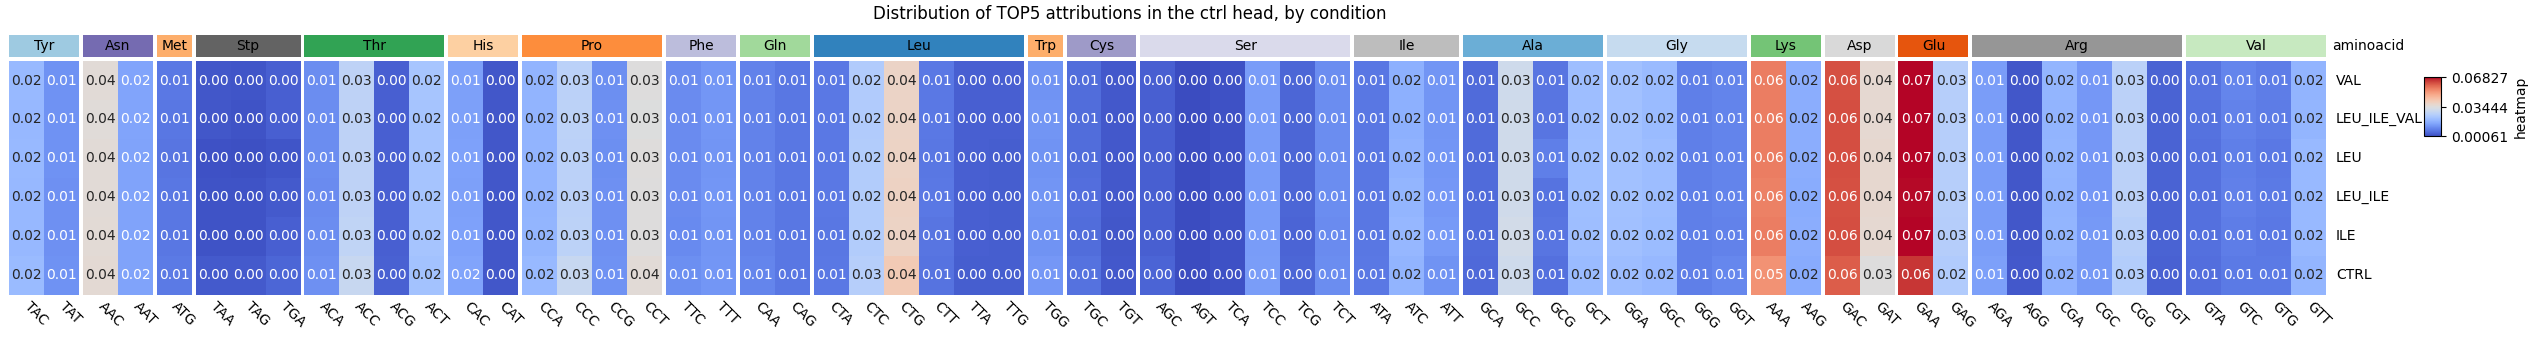

In [11]:
plt.figure(figsize=(30, 3))

cmap = plt.get_cmap('tab20c')
colors = np.array(cmap.colors)
np.random.seed(42)
np.random.shuffle(colors)
randomized_cmap = plt.matplotlib.colors.ListedColormap(colors)

col_ha = pch.HeatmapAnnotation(aminoacid=pch.anno_simple(genetic_code, add_text=True,legend=False,text_kws={'fontsize':10, 'color':'black'},cmap=randomized_cmap, height=5),axis=1)
pch.ClusterMapPlotter(
    data=condition_freq_ctrl_head.T,
    col_split=genetic_code, col_split_gap=1,
    top_annotation=col_ha,
    annot=True, 
    fmt='.2f',
    cmap='coolwarm',
    show_rownames=True,show_colnames=True,
    col_cluster=False,row_cluster=False,
    xticklabels_kws=dict(labelrotation=-45))
plt.suptitle('Distribution of TOP5 attributions in the ctrl head, by condition')
plt.savefig('plots/top5_attr_ctrl_head.png', dpi=400, bbox_inches='tight')

In [12]:
topk = 5
condition_freq_depr_head = {cond: {cod: 0 for cod in genetic_code.index} for cond in conditions}
with h5py.File(DATA_FPATH, 'r') as f:
    transcripts = f['transcript'][:].astype('U') 
    conditions = f['condition'][:].astype('U') 
    for transc_idx in trange(transcripts.shape[0]):
        condition = conditions[transc_idx]
        if condition == 'CTRL':
            continue
        transcript = transcripts[transc_idx]
        trasc_attr = f['attributions_dd'][transc_idx]
        n_codons = int(np.sqrt(trasc_attr.shape[0]))
        trasc_attr = trasc_attr.reshape(n_codons, n_codons)
        sequence = df_trans_to_seq.query('transcript == @transcript').sequence.values[0]
        sequence = np.array(re.findall('...', sequence))
        for top_codon in np.argsort(trasc_attr, 1)[:,-topk:].flatten():
            condition_freq_depr_head[condition][sequence[top_codon]] += 1

condition_freq_depr_head = pd.DataFrame(condition_freq_depr_head)
condition_freq_depr_head = condition_freq_depr_head / condition_freq_depr_head.sum(0)


  0%|          | 0/4252 [00:00<?, ?it/s]

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


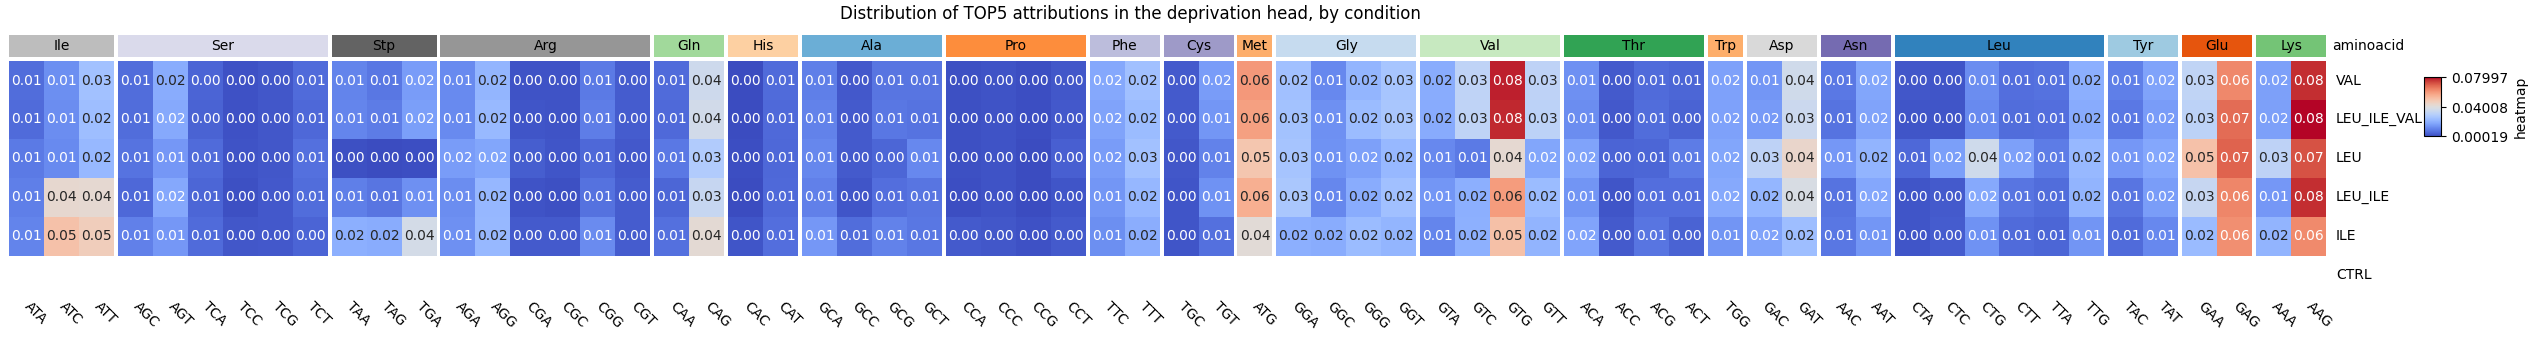

In [14]:
plt.figure(figsize=(30, 3))

cmap = plt.get_cmap('tab20c')
colors = np.array(cmap.colors)
np.random.seed(42)
np.random.shuffle(colors)
randomized_cmap = plt.matplotlib.colors.ListedColormap(colors)

col_ha = pch.HeatmapAnnotation(aminoacid=pch.anno_simple(genetic_code, add_text=True,legend=False,text_kws={'fontsize':10, 'color':'black'},cmap=randomized_cmap, height=5),axis=1)
pch.ClusterMapPlotter(
    data=condition_freq_depr_head.T,
    col_split=genetic_code, col_split_gap=1,
    top_annotation=col_ha,
    annot=True, 
    fmt='.2f',
    cmap='coolwarm',
    show_rownames=True,show_colnames=True,
    col_cluster=False,row_cluster=False,
    xticklabels_kws=dict(labelrotation=-45))
plt.suptitle('Distribution of TOP5 attributions in the deprivation head, by condition')
plt.savefig('plots/top5_attr_depr_head.png', dpi=400, bbox_inches='tight')